# Project 3
Griffith Stites and Alex Hindelang

# Question: How does the fluid in which a penguin swims change its maximum velocity and swim time?

We are modeling the motion of a penguin in olympic-sized swimming pool filled with different fluids to test how its motion is affected.

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# import matlab like plotting functions
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
from scipy import signal
import math

# Model

### Assumptions
* Temperature changes for the fluid do not significantly change density. We choose based off of the listed temperature from the [Engineering Toolbox Chart](https://www.engineeringtoolbox.com/liquids-densities-d_743.html "Engineering Toolbox").
* The force the penguin exerts on the fluid does not change based on fluid density. We made this assumption because it makes sense that there is a maximum force the penguin can exert regardless of density. For example, if it was pushing against an infinitely dense solid it could not exert an infinite force. However, it also makes sense that there would be a fluid that was not dense enough to exert maximum force onto it (like air). We chose to ignore this because although we have fluids heavier and lighter than sea water, they are not at either extreme.
* Penguins flap their flippers 50% of the time when exerting maximum force.
* When penguins reset their flippers back to the ready to propel positions, they do not push themselves backwards at all. This assumption was made because we figured the force would be relatively small as penguins are efficient and aerodynamic swimmers.

### Schematic Diagram 

![](https://raw.githubusercontent.com/ahindelang/ModSimPy/master/code/Untitled-1.png)

This is a 1-dimensional model, so the penguin only moves in the positive x direction. The drag force is opposite to this. The simulation ends when the penguin reaches the other side of an Olympic swimming pool, which is 50 meters long.

### Differential Equations

![](https://raw.githubusercontent.com/ahindelang/ModSimPy/master/dx.PNG)

The change in distance over time is simply the velocity. The slope function calculates the velocity using a separate differential equation.

![](https://raw.githubusercontent.com/ahindelang/ModSimPy/master/dv.PNG)

Fp refers to the force of the penguin. The term in parentheses is the drag equation: Cd is the coefficient of drag, rho is the fluid density, v is the velocity, and A is the reference area. The difference between these two is the total force propelling the penguin forward. This is divided by m (mass of the penguin) to find acceleration according to Newton's 2nd Law of Motion.

Our model uses force equations to derive the velocity and distance traveled of a penguin. It runs a simulation of the force of the penguin swimming versus the drag force and records the time it takes for the penguin to travel the length of an Olympic swimming pool.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
km = UNITS.kilometer
hr = UNITS.hour
s = UNITS.second
N = UNITS.newton
;

''

We declared the values of different liquid densities: sea water, syrup, and propyl alcohol. Sea water was chosen as it is the natural fluid of a penguin and can be used as a control. It is also necessary for finding the force of a penguin based on the max speed since max speed for a penguin data is usually taken in sea water. Syrup was chosen as a fluid denser than sea water, and propyl alcohol as one less dense.

These liquid densities were declared outside of our Params object so we could easily edit our params and system later.

We do the same for the mass of the penguin, so if we choose to add more species later we can alter it. The current penguin is the Gentoo penguin, which is the fastest of all penguins. We include the penguin's mass, max speed, and the flapping speed of the penguin (Based off of watching a [Gentoo Penguin Swim](https://www.youtube.com/watch?v=_TXKiz_DGc4 "Video")).

The other parameters are as follows:

C_d = Coeffient of drag of the penguin

frontal_area = The frontal area of the penguin

velocity_init = Starting velocity of the penguin

pool_length = Length of the pool (Based off an Olympic swimming pool)

The Coefficient of drag and frontal area were calculated based off information found in [this paper](jeb.biologists.org/content/jexbio/87/1/357.2.full.pdf "Paper").

In [3]:
rho_sea_water = 1025 * kg/m**3
rho_syrup = 1370 * kg/m**3
rho_propyl_alcohol = 800 * kg/m**3

gentoo_mass =  5.8967 * kg
gentoo_max_average_speed = 10 * m / s
gentoo_flap_rate = 3 #Number of times per second the penguin flaps its flippers

params = Params(rho = rho_sea_water,
                C_d = 0.07,
                frontal_area = 0.02 * m**2,
                velocity_init = 0 * m / s,
                pool_length = 50 * m,
                p_mass = gentoo_mass,
                p_max_avg_speed = gentoo_max_average_speed,
                p_flap_speed = 1/gentoo_flap_rate
)

,values
rho,1025.0 kilogram / meter ** 3
C_d,0.07
frontal_area,0.02 meter ** 2
velocity_init,0.0 meter / second
pool_length,50 meter
p_mass,5.8967 kilogram
p_max_avg_speed,10.0 meter / second
p_flap_speed,0.333333


We can then build a system object using the parameters we have. This includes a State object, init, of the distance traveled and velocity of the penguin.

The system object also includes a parameter "f_penguin_calc" which tells our "force_penguin" (later) function which force_penguin wave model to use (Either sawtooth or sine, more later).

In [4]:
def make_system(params):
    """Make a system object.
    
    params: Params object with
    
    returns: System object"""
    unpack(params)
    init = State(x=0 * m, v=velocity_init)
    t_end = 100 * s
    f_penguin_calc = 'Sawtooth'
    
    return System(params, init=init, t_end=t_end, f_penguin_calc=f_penguin_calc)

In [5]:
system = make_system(params)

,values
rho,1025.0 kilogram / meter ** 3
C_d,0.07
frontal_area,0.02 meter ** 2
velocity_init,0.0 meter / second
pool_length,50 meter
p_mass,5.8967 kilogram
p_max_avg_speed,10.0 meter / second
p_flap_speed,0.333333
init,x 0 meter v 0.0 meter / secon...
t_end,100 second


This function plots the distance and velocity vs. time in labeled plots. It also calls on three functions: plot_info, calc_total_time, and calc_max_speed. These three functions provide succint information for the result.

In [6]:
def analyze_results(results, system, title):
    """Plot the results of a penguin model and provide summary statements.
    
    results: Dataframe with the results of the model
    system: System object for the model
    title: String with title of the model"""
    
    plot_info(system)
    
    #Changes the size of the figure
    figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
    #Changes the font of the figure
    font = {'family' : 'DejaVu Sans',
            'weight' : 'normal',
            'size'   : 30}
    matplotlib.rc('font', **font)

    #Creates the position vs time plot
    plt.subplot(1, 2, 1)
    plt.plot(results.index, results.x, color='lightgreen', linewidth=7.0)
    plt.title(title + ': Position vs Time', fontsize = 40)
    plt.xlabel('Time (Seconds)', fontsize = 20)
    plt.ylabel('Position (Meters)', fontsize = 20)
    
    #Creates the velocity vs time plot
    plt.subplot(1, 2, 2)
    plt.plot(results.index, results.v, color='lightblue', linewidth=7.0)
    plt.title(title + ': Velocity vs Time', fontsize = 40)
    plt.xlabel('Time (Seconds)', fontsize = 20)
    plt.ylabel('Velocity (m/s)', fontsize = 20)
    
    plt.show()
    
    calc_total_time(results)
    calc_max_speed(results)
    calc_avg_speed(results)

This function returns the details of the independent variables: penguin mass and fluid density. It also prints the name of the penguin force model used: sawtooth or sine wave.

In [7]:
def plot_info(system):
    """Print the penguin mass, fluid density, and penguin force model for the plot.
    
    system: System object
    """
    print('\x1b[1;31m'+'Penguin force model: '+'\x1b[0m', 
          '\x1b[1;31m'+ system.f_penguin_calc +'\x1b[0m')
    p_mass = system.p_mass
    p_mass_str = str(p_mass)
    print('\x1b[1;31m'+'Penguin mass: '+'\x1b[0m', 
          '\x1b[1;31m'+ p_mass_str +'\x1b[0m')
    rho = system.rho
    rho_str = str(rho)
    print('\x1b[1;31m'+'Fluid density: '+'\x1b[0m', 
          '\x1b[1;31m'+ rho_str +'\x1b[0m')

This function prints the time it took for the penguin to reach the other side of the swimming pool.

In [8]:
def calc_total_time(results):
    """Calculate and print the total time.
    
    results: DataFrame
    """
    time = round(results.last_valid_index(), 2)
    time_str = str(time)  
    print('\x1b[1;31m'+'The total time it took the penguin to get to the end of the pool was'+'\x1b[0m', 
          '\x1b[1;31m'+ time_str +'\x1b[0m', '\x1b[1;31m'+'seconds.'+'\x1b[0m')

This function prints the maximum speed the penguin reaches when it swims.

In [9]:
def calc_max_speed(results):
    """Calculate and print the max speed of the penguin in the fluid.
    
    results: DataFrame
    """
    max_speed = results.v.max()
    max_speed_str = str(round(max_speed, 2))
    
    max_speed_kph = round ((max_speed * 3.6), 2)
    max_speed_kph_str = str(max_speed_kph)
    
    print('\x1b[1;31m'+'The max speed of the penguin was'+'\x1b[0m', 
          '\x1b[1;31m'+ max_speed_str +'\x1b[0m', 
          '\x1b[1;31m'+'m/s or'+'\x1b[0m',
          '\x1b[1;31m'+ max_speed_kph_str +'\x1b[0m',
          '\x1b[1;31m'+'kph.'+'\x1b[0m')

This function prints the average speed of the penguin throughout the simulation.

In [10]:
def calc_avg_speed(results):
    """Calculate and print the average speed of the penguin in the fluid.
    
    results: DataFrame
    """
    avg_speed = results.v.mean()
    avg_speed_str = str(round(avg_speed, 2))
    
    avg_speed_kph = round ((avg_speed * 3.6), 2)
    avg_speed_kph_str = str(avg_speed_kph)
    
    print('\x1b[1;31m'+'The average speed of the penguin was'+'\x1b[0m', 
          '\x1b[1;31m'+ avg_speed_str +'\x1b[0m', 
          '\x1b[1;31m'+'m/s or'+'\x1b[0m',
          '\x1b[1;31m'+ avg_speed_kph_str +'\x1b[0m',
          '\x1b[1;31m'+'kph.'+'\x1b[0m')

Our force drag function computes a force opposite the direction of the penguin's velocity. This value is a scalar as our model only functions in one dimension and using vectors did not simplify the model. It uses the drag force equation:

![](http://chubbyrevision.weebly.com/uploads/1/0/5/8/10584247/1329940531.jpg)

#### Drag Force Model

The coefficient of drag and frontal area of the penguin do not change between simulations. However, the fluid density (rho) changes with each simulation. Velocity changes throughout the course of the simulation.

In [11]:
def force_drag(V, system):
    """Computes drag force in the opposite direction of 'v'.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: scalar drag force
    """
    unpack(system)
    f_drag_mag = -rho * V**2 * C_d * frontal_area / 2
    return f_drag_mag

### Penguin Force

#### Average Penguin Force

To compute the average force of the penguin swimming, we back-calculate it based off of the drag force. The assumption is that, at terminal velocity, the force of the penguin is equal to the drag force. Therefore, the force of the penguin has the same magnitude but opposite direction of the drag force at the penguin's maximum speed in salt water.

#### Instantaneous Penguin Force

Although we can find the average force of the penguin on the fluid, this force is not constant. To move, the penguin must move its flippers in the water to propel itself. When the penguin is pushing back into the water, it exerts force on the fluid and accelerates. When the penguin is pulling its flippers from back to front, it is setting itself up for another push and is slowing down due to the drag force of the water. It is not accelerating at this point.

To account for this, we need to find the instantaneous penguin force. This will allow us to find the instantaneous acceleration. 

#### Sawtooth Force Model

Since the penguin is only exerting a force around 50% of the time, a sawtooth model seemed like a logical first step. The assumption that the penguin only exerts force around 50% of the time is a rough estimate from watching [Gentoo penguins swimming](https://www.youtube.com/watch?v=_TXKiz_DGc4 "Video"). We also liked the sawtooth model because a penguin is going to have times when it makes better contact with the water and can exert more force, just as  a Sawtooth model slopes to a point and goes back down.

The sawtooth function has a period which matches the flapping rate of our penguin. The magnitude of the sawtooth wave is four times the average force exerted by the penguin (More on this later).

When the sawtooth function is zero or below, an "if" statement is used to set the force exerted by the penguin to zero. This is another assumption that the penguin does not push itself backwards while resetting itself. Penguins are relatively aerodynamic and efficient so this is logical. 

The magnitude of the sawtooth wave must be four times the average force exerted by the penguin for the average output to be equivelent to the average force exerted by the penguin (Given enough time). 

In [12]:
def force_penguin_sawtooth(t, system):
    """Computes the force the penguin exerts on the fluid using a sawtooth function.
    
    t: time
    system: System object
    
    returns: Scalar penguin force"""
    params_penguin = params
    params_penguin.rho = rho_sea_water
    system_penguin = make_system(params_penguin)
    f_penguin_avg = - force_drag(system.p_max_avg_speed, system_penguin)
    
    amplitude = 4 * f_penguin_avg
    wavelength = 1/system.p_flap_speed
    p_flap = amplitude * signal.sawtooth(wavelength * 2 * pi * t, 0.5)
    if (p_flap > 0 * N):
        f_penguin = p_flap
    else: 
        f_penguin = 0 * N
    return f_penguin

#### Sine Force Model

We also tried calculating force of the penguin using a sine wave to represent the flipper force. We thought a sine wave might make more sense as it is less abrupt than a sawtooth model (More time spent exerting an efficient force). This seemed more representative of how a penguin pushes against the water: The maximum surface area of the flipper is used to propel the penguin halfway through a "flap". Towards the beginning and end of the motion the penguin is much less efficient than in the middle.

The wavelength matches the flap rate of the penguin. The amplitude is pi * f_penguin_avg (where f_penguin_avg is the average force of the penguin on the fluid). This is done such that the average output of our function, where outputs below zero result in zero force, is equal to the average force of the penguin.

The average value of one arc of a sine wave (With an amplitude of 1) is .636619772367581. The inverse of this is pi / 2. This pi / 2 value needs to be multiplied by f_penguin_avg to result in the average output of the positive portion of the sin wave to equal f_penguin_avg.

However, since there is also a portion of our function where the output is below zero and the penguin force is zero we need to multiply the value by two again. Hence why pi * f_penguin_avg for our amplitude results in an average penguin force of f_penguin_avg.

In [13]:
def force_penguin_sin(t, system):
    """Computes the force the penguin exerts on the fluid using a sin function.
    
    t: time
    system: System object
    
    returns: Scalar penguin force"""
    params_penguin = params
    params_penguin.rho = rho_sea_water
    system_penguin = make_system(params_penguin)
    f_penguin_avg = - force_drag(system.p_max_avg_speed, system_penguin)
    
    amplitude = pi * f_penguin_avg
    wavelength = 1/system.p_flap_speed
    p_flap = amplitude * math.sin(wavelength * 2 * pi * t)
    if (p_flap > 0 * N):
        f_penguin = p_flap
    else: 
        f_penguin = 0
    return f_penguin

We wrote a force_penguin function to allow us to choose between the sin and sawtooth method with a change system parameter. This allows us to easily see the results of the model for both examples.

In [14]:
def force_penguin(t, system):
    """Determines which penguin force function to use based off the system function.
    
    t: time
    system: System Object
    
    returns: Scalar penguin force"""
    
    if (system.f_penguin_calc == 'Sawtooth'):
        f_penguin = force_penguin_sawtooth(t, system)
    if (system.f_penguin_calc == 'Sin'):
        f_penguin = force_penguin_sin(t, system)
    if (system.f_penguin_calc != 'Sin' and system.f_penguin_calc != 'Sawtooth'):
        print ('Invalid f_penguin_calc in system object.')
    return f_penguin

The slope function returns the velocity and acceleration, calculated from the forces on the penguin.

In [15]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State ()
    t: time
    system: System object with
    
    returns: derivatives of y and v
    """
    x, v = state
    unpack(system)    

    f_drag = force_drag(v, system)
    f_penguin = force_penguin(t, system)
    
    f_total = f_penguin + f_drag
    
    dydt = v
    dvdt = f_total / p_mass #acceleration
    
    return dydt, dvdt

In order to better communicate the differences between fluids, we want to see how long it takes for the penguin to swim the span of an Olympic swimming pool. The following event function stops the solver function when the penguin reaches the end of the pool.

In [16]:
def event_func(state, t, system):
    """Return the ditance of the penguin in the pool.
    
    state: state object with the position and velocity of the penguin
    t: int representing the time the model is at
    system: system object with the model params
    """
    x, v = state
    return x - system.pool_length

# Results

Testing the Gentoo penguin in the different substances.

First the results in the control substance: sea water. The Sawtoon penguin force model is used first.

Penguin force model:  Sawtooth
Penguin mass:  5.8967 kilogram
Fluid density:  1025.0 kilogram / meter ** 3


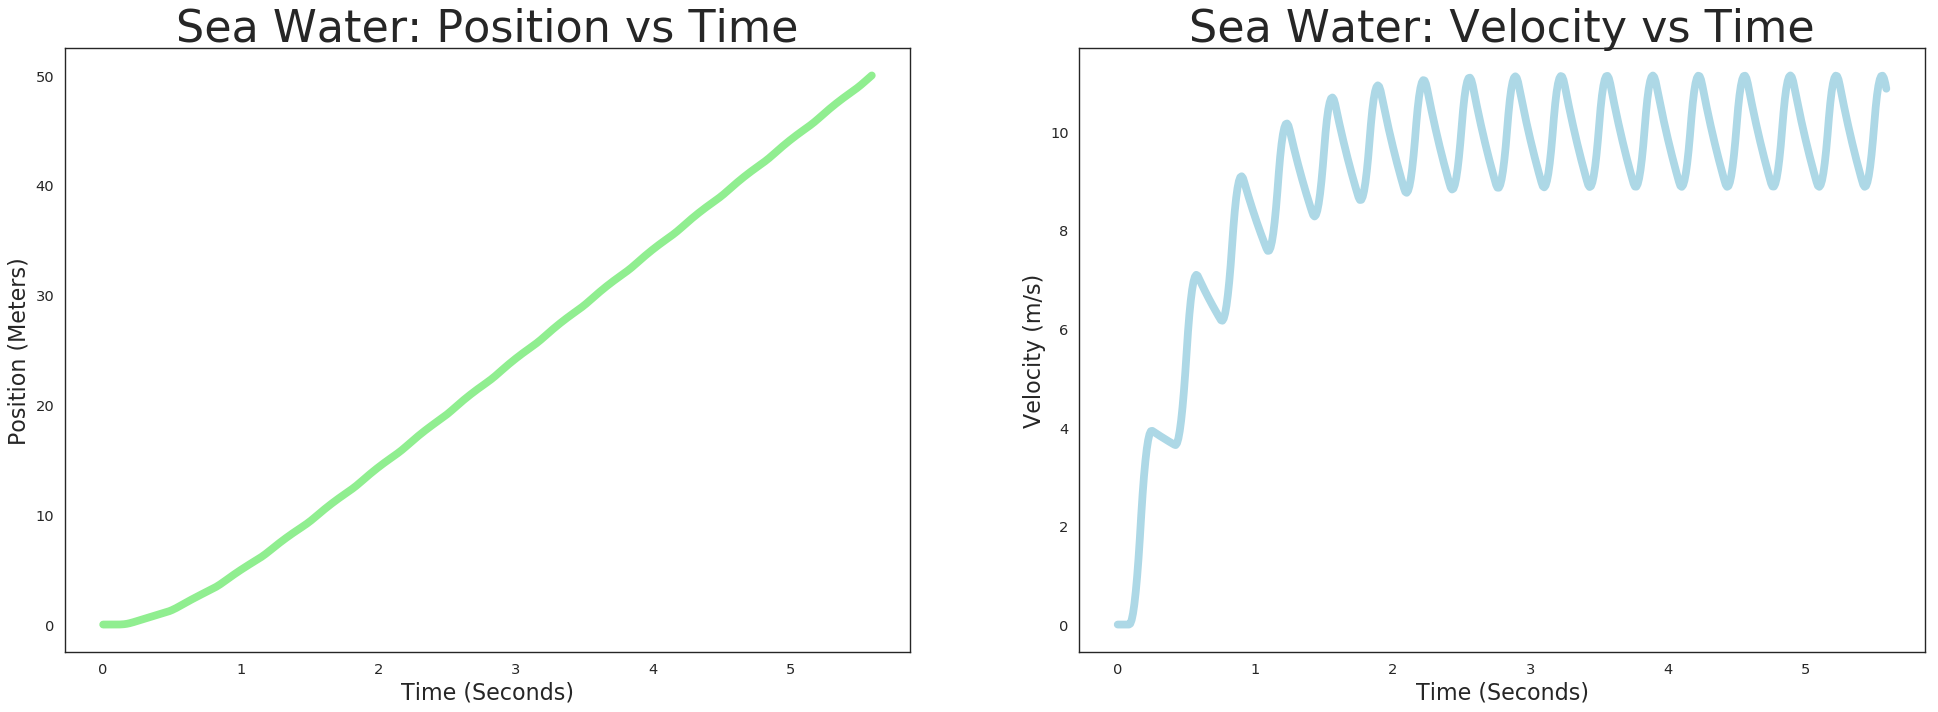

The total time it took the penguin to get to the end of the pool was 5.59 seconds.
The max speed of the penguin was 11.14 m/s or 40.1 kph.
The average speed of the penguin was 8.88 m/s or 31.97 kph.


In [17]:
params.rho = rho_sea_water
system = make_system(params)
results, details = run_ode_solver(system, slope_func, events=event_func, max_step =.01)
analyze_results(results, system, 'Sea Water')

The same thing except now with the Sinee penguin force model. The Sin penguin force model will be used for the rest of the results (More on this later).

Penguin force model:  Sin
Penguin mass:  5.8967 kilogram
Fluid density:  1025.0 kilogram / meter ** 3


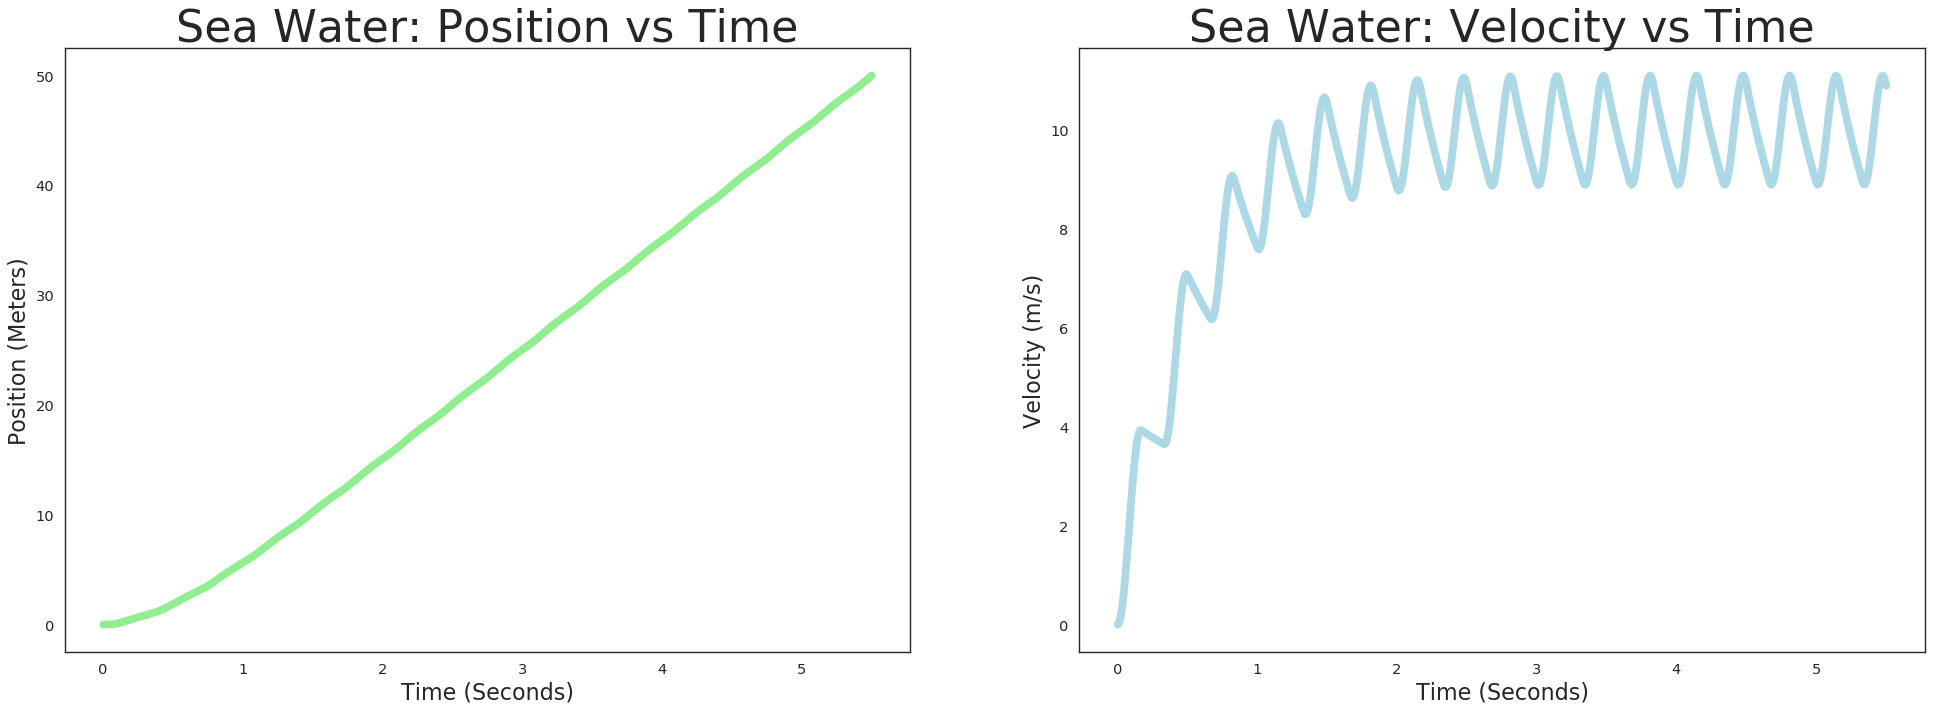

The total time it took the penguin to get to the end of the pool was 5.5 seconds.
The max speed of the penguin was 11.11 m/s or 40.0 kph.
The average speed of the penguin was 9.05 m/s or 32.58 kph.


In [18]:
params.rho = rho_sea_water
system = make_system(params)
system.f_penguin_calc = 'Sin'
results, details = run_ode_solver(system, slope_func, events=event_func, max_step =.01)
analyze_results(results, system, 'Sea Water')

The original question that inspired us to make this model: What happens if a penguin swims in syrup? (Ignoring the sugary effect on the penguin. I choose to believe that the penguin would just want to eat it right up). The syrup helps us to know what would happen if a penguin swam through a thicker substance. It helps us to quantify and visualize the answer to our question.

Penguin force model:  Sin
Penguin mass:  5.8967 kilogram
Fluid density:  1370.0 kilogram / meter ** 3


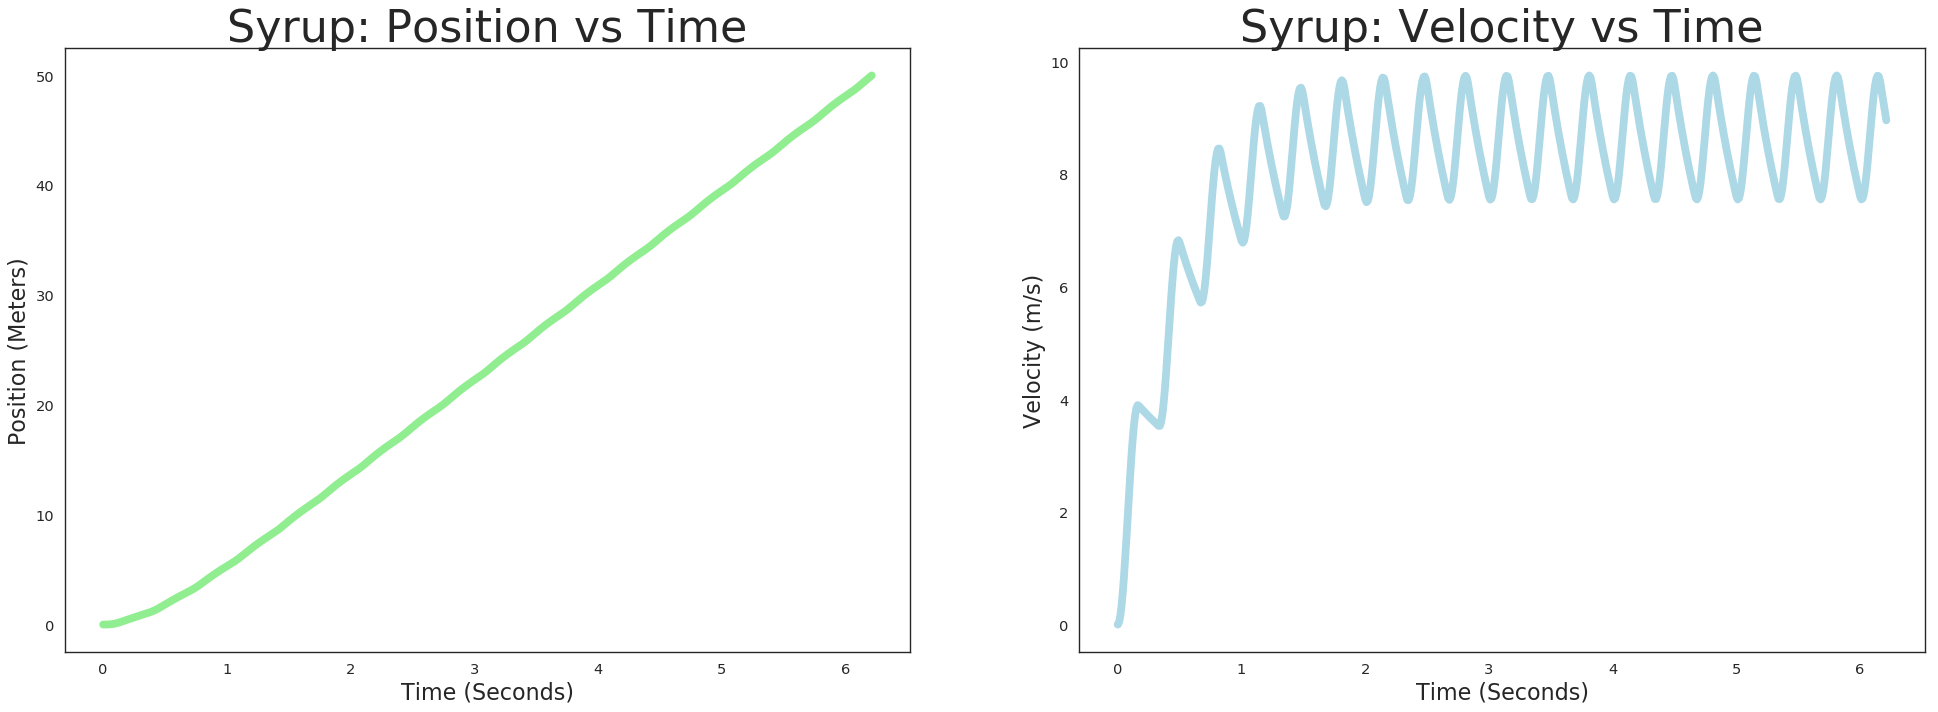

The total time it took the penguin to get to the end of the pool was 6.21 seconds.
The max speed of the penguin was 9.76 m/s or 35.12 kph.
The average speed of the penguin was 8.02 m/s or 28.87 kph.


In [19]:
params.rho = rho_syrup
system = make_system(params)
system.f_penguin_calc = 'Sin'
results, details = run_ode_solver(system, slope_func, events=event_func, max_step =.01)
analyze_results(results, system, 'Syrup')

For our final result, a substance less dense than sea water: propyl alcohol.

Penguin force model:  Sin
Penguin mass:  5.8967 kilogram
Fluid density:  800.0 kilogram / meter ** 3


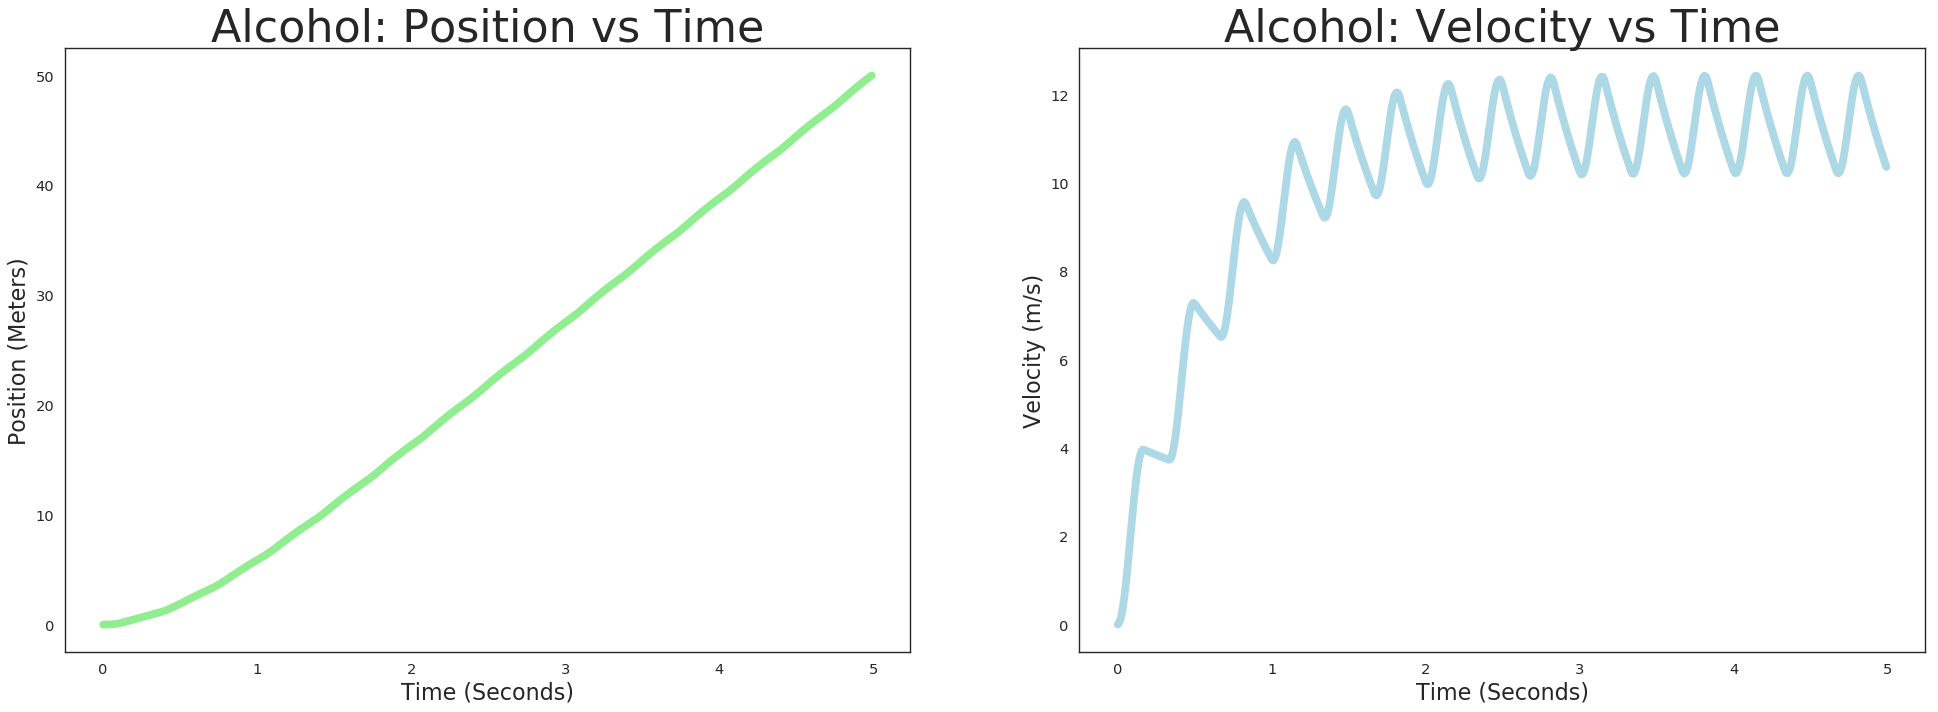

The total time it took the penguin to get to the end of the pool was 4.99 seconds.
The max speed of the penguin was 12.43 m/s or 44.75 kph.
The average speed of the penguin was 9.97 m/s or 35.89 kph.


In [20]:
params.rho = rho_propyl_alcohol
system = make_system(params)
system.f_penguin_calc = 'Sin'
results, details = run_ode_solver(system, slope_func, events=event_func, max_step =.01)
analyze_results(results, system, 'Alcohol')

# Interpretation

#### How the Output and Model answered the Question
Our Model helped us to answer the question by giving us a quantantative and visual answer. The Position vs Time plot and total time print out gave us an overall view of how different fluids change the time it takes the penguin to cover distance. 

The Velocity vs Time plot gave us a good visualization of how a penguin swims. Printing out values such as the max speed and average speed provided a quantative look at the peak velocity the Gentoo penguin was able to reach in each substance.

Doing this in a Python model instead of with a fully algebraic model (Such as one that could be done by hand) allowed us to easily track velocity over time. This is especially seen in how we modeled the force of the penguin on the fluid, as this changes multiple times per second due to the flapping of the penguin's flippers. Using a Python model also made it easy to test multiple fluids quickly and easily.

Overall, having both a position vs time plot and velocity vs time plot, as well as printed summary statements, made it easy to glance just at the results and understand the quantitative, rather than qualitative relationship between penguin movement at different fluids.

#### Model Limitations
All in all, our model does an effective job answering our original question with sufficient accuracy. However, there could be some improvements.

In regards to results, the code does not allow for simple comparison between simulations--readers must compare the distinction between different trials for themselves.

We also did not have time to add different penguins, who may have different results. However, the model does allow for the penguin parameters to be changed.

Because penguins tend to swim in very cold water, the assumption that temperature changes play little role in the density of the fluid may be an incorrect one.

Though a wave function modeling the movement of the penguin's wings and the non-constant force it produces was a good step, it could perhaps have a level of error. Penguins may not swim at full speed for the whole time, so considering the stamina of the penguin could be a next step.

#### Iteration
The biggest iteration our model went through was the change in how we represented the force of the penguin. Originally, our penguin's force was constant, just equivalent to the average force as derived from the drag equation. Although this gave us very similar total time results to our current model, this force model does not accurately represent how a penguin exerts force on the water. 

To fix this, we tested two seperate functions to model the penguin's force exerted on the water: a sawtooth and sine wave. This can be clearly seen in the Velocity vs Time plots. This is another place where our Python model allows us to do more than a simple algebraic one could reasonably accomplish.

Another major area of iteration was in the presentation of data. Originally, there were just the Position vs Time and Velocity vs Time plots. Although these technically display all the essential data, they are hard to parse and quickly differentiate between different fluids. Adding summary statements for the performance of the penguin (total time, max speed, average speed) helped this vastly.